# Benchmark: Schoof in-house dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm

import scvi

np.random.seed(0)
scvi.settings.seed = 0

Global seed set to 0


## Data loading

Let's define the path to the data and load it into anndata.

In [2]:
DATA_DIR = "../../data/schoof_inhouse/"

DATA_PATH1 = os.path.join(DATA_DIR, "carrier.h5ad")
DATA_PATH2 = os.path.join(DATA_DIR, "hBM_raw.h5ad")

In [3]:
adata1 = sc.read_h5ad(DATA_PATH1)

adata1.X[adata1.X == 0] = np.nan
adata1.X = np.log(adata1.X)

In [4]:
adata1

AnnData object with n_obs × n_vars = 562 × 3821
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways'

In [5]:
adata2 = sc.read_h5ad(DATA_PATH2)

adata2.layers["raw_sn"][adata2.layers["raw_sn"] == 0] = np.nan
adata2.layers["raw_sn"] = np.log(adata2.layers["raw_sn"])

In [6]:
adata2

AnnData object with n_obs × n_vars = 2655 × 3075
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-W', 'FSC-H', 'SSC-A', 'SSC-W', 'SSC-H', 'CD38 FACS', 'EMCN FACS', 'CD34 FACS', 'Lineage Cocktail FACS', 'CD123 FACS', 'CD90 FACS', 'CD49f FACS', 'CD45RA FACS', 'CD10 FACS', 'Time', 'Gated Population', 'Gate Path', 'QC leiden', 'Pass Cluster Filter', 'Individual', 'Num Proteins', 'Log2 Sum S/N', 'Pass Cell Filter', 'log2_sum_filter'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways', 'n_cells'
    uns: 'Gated Population_colors', 'Sorted Population_colors'
    layers: 'raw_sn'

## Data Exploration

/home/rasmus/sollertis/school/s11/thesis/MS_mv_modelling/scp/plots.py:83: RuntimeWarning: Mean of empty slice
  x_obs_protein = np.nanmean(x, axis=0)


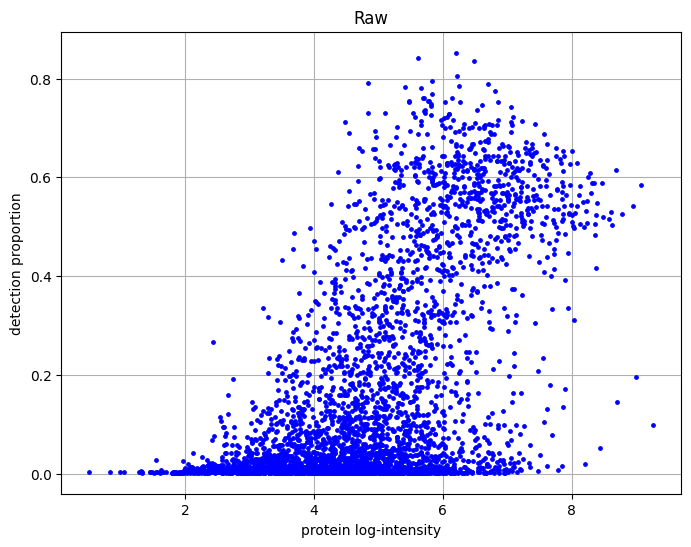

In [7]:
pl.scatter_protein_detection_proportion_and_intensity(adata1.X, title="Raw")

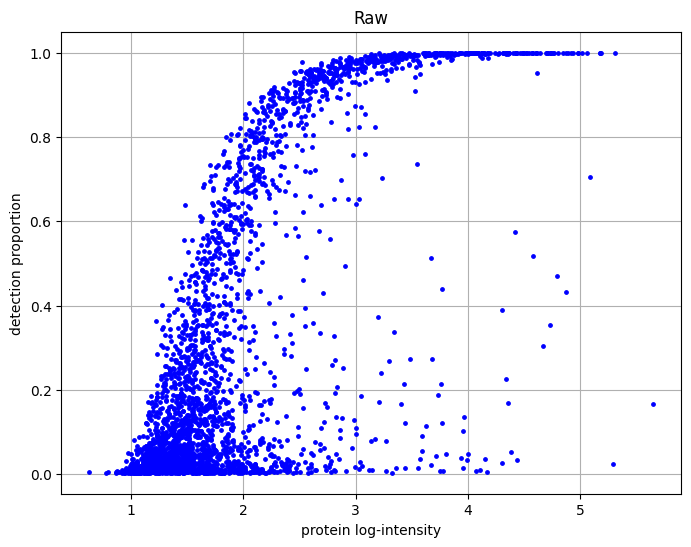

In [8]:
pl.scatter_protein_detection_proportion_and_intensity(adata2.layers["raw_sn"], title="Raw")

In [9]:
print(f"nan intensities: {np.isnan(adata2.layers['raw_sn']).sum() / (adata2.shape[0] * adata2.shape[1]) * 100:.2f}%")

nan intensities: 68.90%


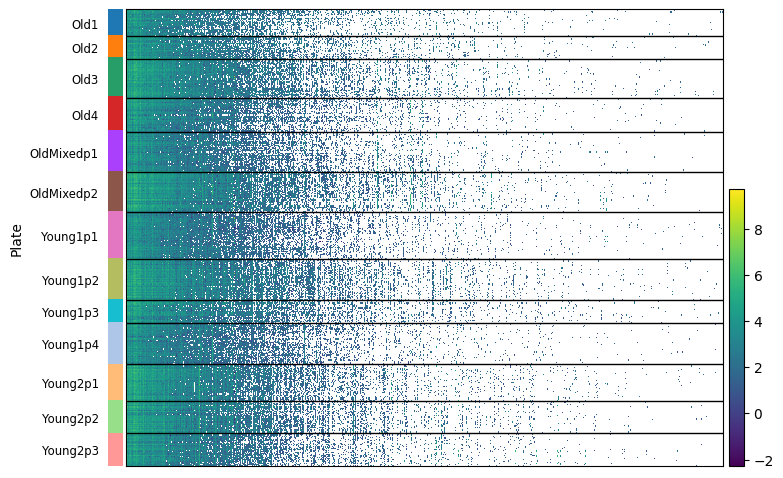

In [10]:
adata2 = utils.sort_anndata_by_missingness(adata2, layer="raw_sn")


sc.pl.heatmap(adata2, layer="raw_sn", var_names=adata2.var_names, groupby="Plate", show_gene_labels=False)

In [11]:
protein_missingness = utils.get_missingness_per_protein(adata2, layer="raw_sn")
print(f"Proteins with no missing values: {np.sum(protein_missingness == 0) / len(protein_missingness) * 100:.2f}%")

Proteins with no missing values: 2.05%


In [9]:
adata2

AnnData object with n_obs × n_vars = 2655 × 3075
    obs: 'File ID', 'Channel', 'File Name', 'Plate', 'Sample', 'Row', 'Column', 'Well', 'Sorted Population', 'FSC-A', 'FSC-W', 'FSC-H', 'SSC-A', 'SSC-W', 'SSC-H', 'CD38 FACS', 'EMCN FACS', 'CD34 FACS', 'Lineage Cocktail FACS', 'CD123 FACS', 'CD90 FACS', 'CD49f FACS', 'CD45RA FACS', 'CD10 FACS', 'Time', 'Gated Population', 'Gate Path', 'QC leiden', 'Pass Cluster Filter', 'Individual', 'Num Proteins', 'Log2 Sum S/N', 'Pass Cell Filter', 'log2_sum_filter'
    var: 'Accession', 'Description', 'Biological Process', 'Cellular Component', 'Molecular Function', 'KEGG Pathways', 'Reactome Pathways', 'WikiPathways', 'n_cells'
    uns: 'Gated Population_colors', 'Sorted Population_colors'
    layers: 'raw_sn'

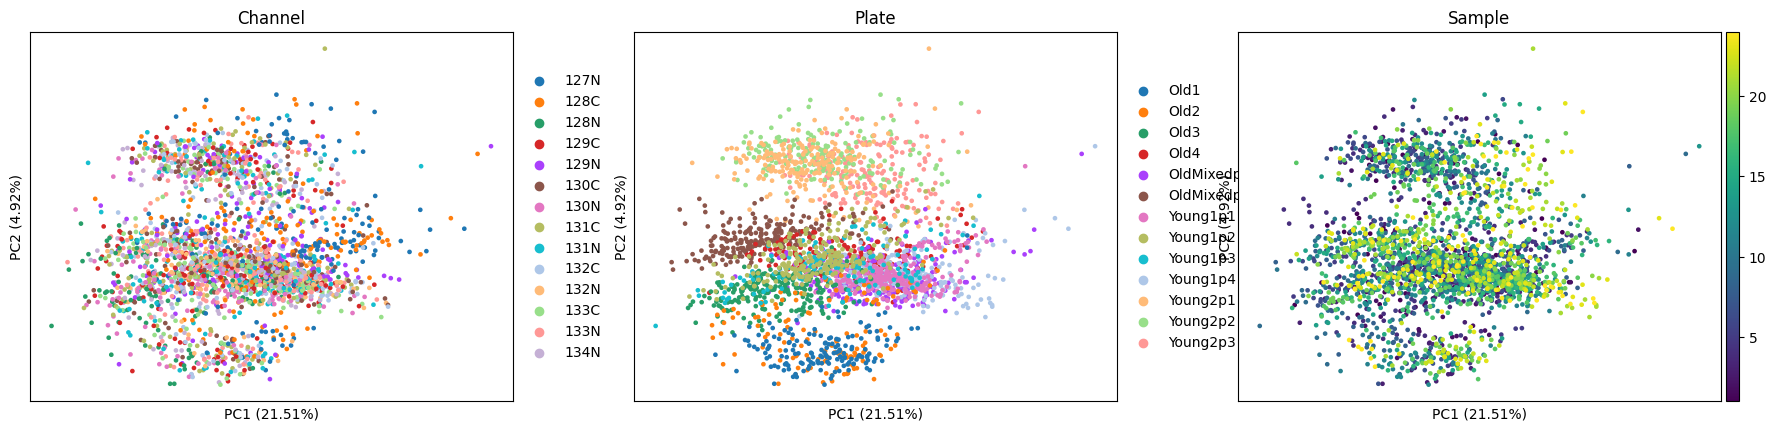

2023-11-28 01:18:55.833182: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 01:18:55.833216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 01:18:55.833240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 01:18:56.823178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


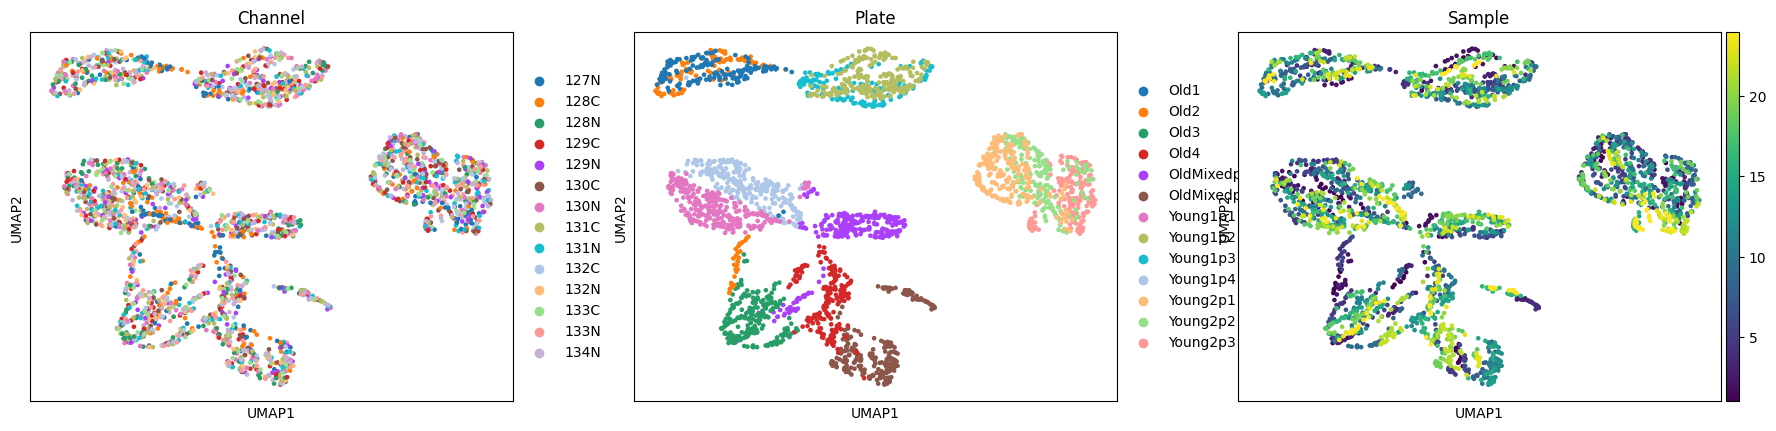

In [10]:
adata2.X = bm.impute_downshifted_normal_sample(adata2, layer="raw_sn")

sc.tl.pca(adata2, n_comps=16)

sc.pl.pca(
    adata2,
    annotate_var_explained=True,
    color=["Channel", "Plate", "Sample"],
    components=["1,2"],
)

sc.pp.neighbors(adata2)
sc.tl.umap(adata2)

sc.pl.umap(
    adata2,
    color=["Channel", "Plate", "Sample"],
)